In [1]:
import scanpy as sc
from tidyverse.dummy import *
from sctools.scplotting import recolor
import gc
import pertpy as pt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
from sctools.composition import compositional_pca, plot_pca_loadings
plt.rcParams["figure.figsize"] = (4,3)

from prop_utils import annotate_qval_to_scCODA_result, renamer

import sys
sys.path.append('..')
from util import load_celltype
from colormaps import color_dict_diagnosis, cmap_subtypes
from matplotlib.colors import ListedColormap

Importing tidyverse


/tmp/ipykernel_150191/4059287409.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
!mkdir /tmp/proportions

mkdir: cannot create directory ‘/tmp/proportions’: File exists


In [3]:
plotfolder = '/tmp/proportions/Tcell_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder, )

# SCCODA
### on the clusters

In [4]:
cluster_name = 'leiden'
A = load_celltype('Tcells')
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)    

In [5]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

In [6]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    A,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

In [7]:
# need to extend cmap by one
cmap_subtypes = ListedColormap(cmap_subtypes.colors + ['lightgrey'])

In [8]:
# cluster_order = A.obs[cluster_name].cat.categories
cluster_order = [
    '1','2','10', # tH
    '3', #Treg
    '0','4','6','12', # cytoT
    '5','9','11',  # NK
    '7','8','13','14' # other
]

In [9]:
cmap_subtypes = ListedColormap(np.array(cmap_subtypes.colors)[[7,8,9, # TH
                                              0,
                                              2,3,4,5,
                                              10,11,12,
                                              1,6,13,14
                                             ]])

In [10]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))

In [11]:
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

/tmp/ipykernel_150191/2991591632.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_150191/2991591632.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


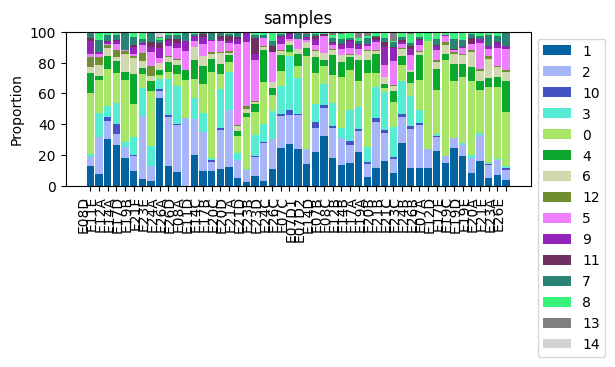

In [12]:
order = []
_snames = data_scanpy_1.obs.index.unique()
for d in diagnosis_ordered:
    order.extend(sorted(data_scanpy_1.obs.query('samplename in @_snames and diagnosis==@d').index))

set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(6,2), show=False, palette=cmap_subtypes,
    level_order=order
)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Tcell_proportions_per_sample.svg')
set_matplotlib_formats('png')

In [13]:
# clustered_heatmap_from_sccoda_CLR(data_scanpy_1[:, cluster_order], barcolormap=cmap_subtypes);

## CODA-PCA

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1078.39it/s]


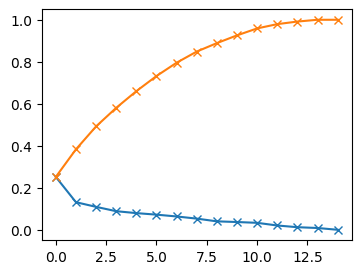

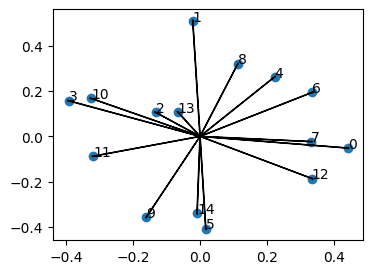

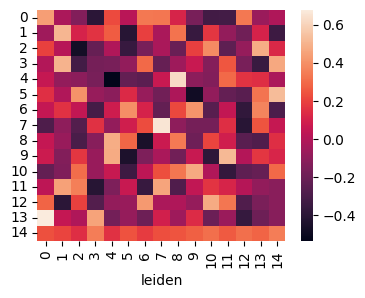

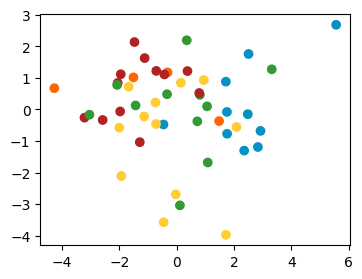

In [14]:
pca, scaler, x_pca_posterior, principal_components_df = compositional_pca(data_scanpy_1)
plt.plot(pca.explained_variance_ratio_, 'x-')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'x-')

# plot_pca_with_uncertainty()
plt.figure()
plot_pca_loadings(principal_components_df)
plt.figure()

sns.heatmap(principal_components_df)

plt.figure()
plt.scatter(x_pca_posterior[:,0], x_pca_posterior[:,1], c=[color_dict_diagnosis[_] for _ in data_scanpy_1.obs.diagnosis])

## Barplots

/tmp/ipykernel_150191/2742146783.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


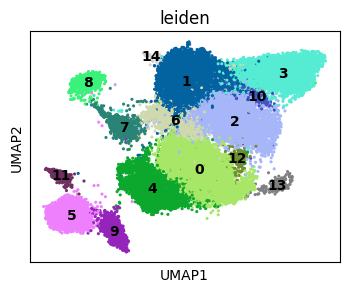

In [15]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=[cluster_name], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Tcell_umap.svg')
plt.savefig(f'{plotfolder}/Tcell_umap.png')

/tmp/ipykernel_150191/4098925493.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_150191/4098925493.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


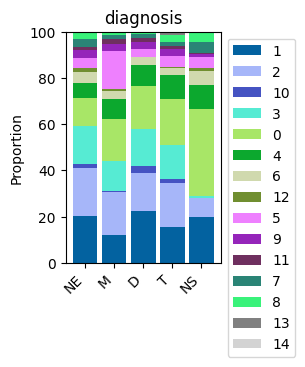

In [16]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False, palette=cmap_subtypes
)
fig.figure.savefig(f'{plotfolder}/Tcell_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

In [17]:
for diag in ['NE','M','D','T','NS']:
    fraction = data_scanpy_1[data_scanpy_1.obs.diagnosis==diag][:, "0"].X.sum() / data_scanpy_1[data_scanpy_1.obs.diagnosis==diag].X.sum()
    print(f"{diag}: {100*fraction:.2f}%")

NE: 12.08%
M: 18.57%
D: 18.61%
T: 19.71%
NS: 37.44%


In [18]:
for diag in ['NE','M','D','T','NS']:
    fraction = data_scanpy_1[data_scanpy_1.obs.diagnosis==diag][:, "5"].X.sum() / data_scanpy_1[data_scanpy_1.obs.diagnosis==diag].X.sum()
    print(f"{diag}: {100*fraction:.2f}%")

NE: 4.58%
M: 16.63%
D: 3.24%
T: 4.76%
NS: 5.00%


In [19]:
for diag in ['NE','M','D','T','NS']:
    fraction = data_scanpy_1[data_scanpy_1.obs.diagnosis==diag][:, "1"].X.sum() / data_scanpy_1[data_scanpy_1.obs.diagnosis==diag].X.sum()
    print(f"{diag}: {100*fraction:.2f}%")

NE: 20.27%
M: 11.94%
D: 22.54%
T: 15.63%
NS: 19.71%


In [20]:
set_matplotlib_formats('png')

/tmp/ipykernel_150191/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Tcell_proportions//proportions_per_diagnosis_ncells.svg


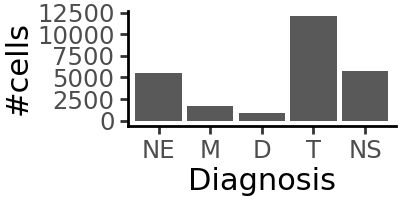

In [21]:
p = pn.ggplot(pd.DataFrame({'n_cells': data_scanpy_1.obs.groupby('diagnosis').n_cells.sum()}).reset_index(), pn.aes(x='diagnosis', y='n_cells')) + pn.geom_bar(stat='identity') \
+ pn.theme_classic() + pn.theme(figure_size=(2,1)) + pn.labs(x='Diagnosis', y='#cells')
p.save(f'{plotfolder}/proportions_per_diagnosis_ncells.svg')
p

In [22]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs[cluster_name], categories=cluster_order), name=cluster_name, index=A.obs[cluster_name].index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/tmp/ipykernel_150191/1216210536.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Tcell_proportions//Tcell_proportions_per_cluster.svg
/tmp/ipykernel_150191/1216210536.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


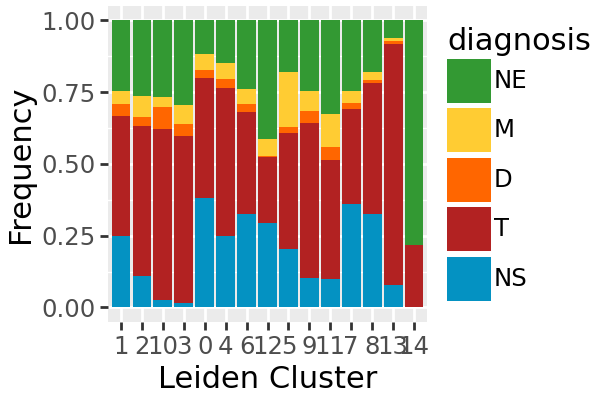

In [23]:
set_matplotlib_formats('svg')
p = pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Leiden Cluster', y='Frequency')

p.save(f'{plotfolder}/Tcell_proportions_per_cluster.svg')
set_matplotlib_formats('png')
p

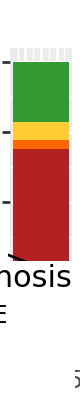

In [24]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'count': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,4)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Tcell_proportions//proportions_per_cluster_ncells.svg


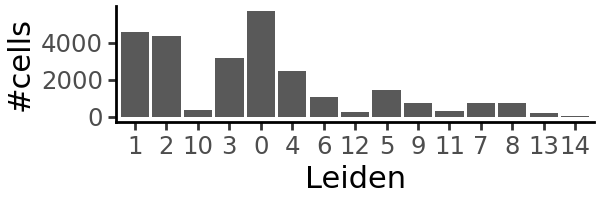

In [25]:
p = pn.ggplot(pd.DataFrame({'n_cells': q.reset_index().melt(id_vars=['leiden']).groupby('leiden').value.sum()}).reset_index(), pn.aes(x='leiden', y='n_cells')) + pn.geom_bar(stat='identity') \
 + pn.theme_classic() + pn.theme(figure_size=(3,1)) + pn.labs(x='Leiden', y='#cells')
p.save(f'{plotfolder}/proportions_per_cluster_ncells.svg')
p

# MCMC

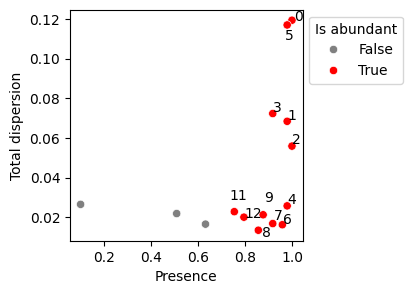

In [26]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, figsize=(3,3), abundant_threshold=0.75); plt.show()

In [32]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NE')) + patient + procedure",
    reference_cell_type="4",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|███████████| 11000/11000 [17:36<00:00, 10.42it/s, 511 steps of size 1.18e-02. acc. prob=0.86]


AnnData object with n_obs × n_vars = 49 × 15
    obs: 'samplename', 'procedure', 'diagnosis', 'patient', 'n_cells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]', 'effect_df_procedure[T.resection]'

In [33]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])

scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)

scCODA_result.to_csv(f'{plotfolder}/MCMC_diag_procedure_patient.csv')
scCODA_result[scCODA_result['Final Parameter'] != 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


Final Parameter  HDI 3%  HDI 97%  \
Covariate                         Cell Type                                     
C(diagnosis, Treatment('NE'))T.M  5                 0.991607   0.565    1.421   
C(diagnosis, Treatment('NE'))T.NS 0                 0.947479   0.571    1.279   
                                  2                -0.507791  -0.878   -0.064   
                                  3                -2.018647  -2.620   -1.424   
patientT.E17                      0                 0.639017   0.202    1.042   
patientT.E20                      2                 0.767491   0.282    1.217   
                                  3                 0.698630   0.148    1.189   
patientT.E21                      1                -0.742416  -1.220   -0.269   
                                  5                 1.037365   0.576    1.437   
patientT.E24                      0                -0.811684  -1.446   -0.187   
patientT.E26                      0                -0.410870  -0.790    0.002   
                                  2                 0.440024  -0.003    0.772   

                                                SD  Inclusion probability  \
Covariate                         Cell Type                                 
C(diagnosis, Treatment('NE'))T.M  5          0.227                 0.9993   
C(diagnosis, Treatment('NE'))T.NS 0          0.179                 1.0000   
                                  2          0.245                 0.8951   
                                  3          0.315                 1.0000   
patientT.E17                      0          0.238                 0.9776   
patientT.E20                      2          0.265                 0.9851   
                                  3          0.304                 0.9519   
patientT.E21                      1          0.260                 0.9900   
                                  5          0.225                 0.9997   
patientT.E24                      0          0.347                 0.9836   
patientT.E26                      0          0.243                 0.8664   
                                  2          0.240                 0.8752   

                                             Expected Sample  \
Covariate                         Cell Type                    
C(diagnosis, Treatment('NE'))T.M  5                58.883225   
C(diagnosis, Treatment('NE'))T.NS 0               225.280317   
                                  2                47.802365   
                                  3                 8.586740   
patientT.E17                      0               157.236756   
patientT.E20                      2               142.493634   
                                  3               108.249334   
patientT.E21                      1                42.510139   
                                  5                66.721293   
patientT.E24                      0                47.646940   
patientT.E26                      0                62.095387   
                                  2               132.232954   

                                             log2-fold change  pvalue  \
Covariate                         Cell Type                             
C(diagnosis, Treatment('NE'))T.M  5                  1.326393  0.0007   
C(diagnosis, Treatment('NE'))T.NS 0                  1.223657  0.0000   
                                  2                 -0.875854  0.1049   
                                  3                 -3.055558  0.0000   
patientT.E17                      0                  0.704875  0.0224   
patientT.E20                      2                  0.699889  0.0149   
                                  3                  0.600545  0.0481   
patientT.E21                      1                 -1.060999  0.0100   
                                  5                  1.506683  0.0003   
patientT.E24                      0                 -1.017609  0.0164   
patientT.E26                      0                 -0.635

In [34]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_3936609/1088038068.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


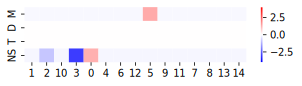

In [37]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(5, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/matrix_scCODA.svg')

In [36]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type,0,1,10,11,12,13,14,2,3,4,5,6,7,8,9
Covariate,,,,,,,,,,,,,,,
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M,-0.104193,-0.104193,-0.104193,-0.104193,-0.104193,-0.104193,-0.104193,-0.104193,-0.104193,-0.104193,1.326393,-0.104193,-0.104193,-0.104193,-0.104193
NS,1.223657,-0.143266,-0.143266,-0.143266,-0.143266,-0.143266,-0.143266,-0.875854,-3.055558,-0.143266,-0.143266,-0.143266,-0.143266,-0.143266,-0.143266
T,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E17,0.704875,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032,-0.217032


/tmp/ipykernel_3936609/3154158120.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


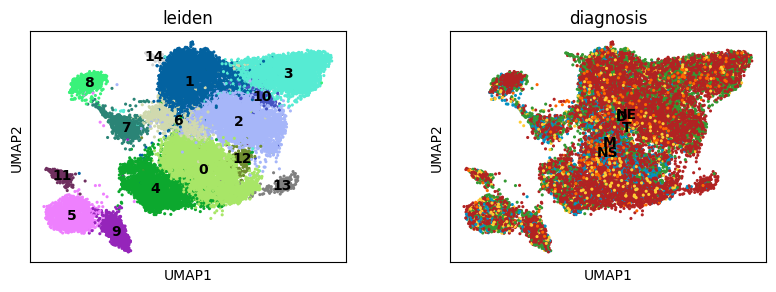

In [38]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

# Markers 

In [39]:
A.raw = A

In [40]:
from sctools.pipeline import differential_expression_michi_kallisto_recipe
differential_expression_michi_kallisto_recipe(A, groupby='leiden', min_in_group_fraction=0.5, max_out_group_fraction=0.5)

02/27/2025 07:02:28 PM doing csr->csc
02/27/2025 07:02:29 PM done csr->csc
02/27/2025 07:02:29 PM Actual DE analysis via `rank_genes_groups`
02/27/2025 07:05:06 PM Done: Actual DE analysis via `rank_genes_groups`
02/27/2025 07:05:06 PM doing csc->csr
02/27/2025 07:05:07 PM done csc->csr
02/27/2025 07:05:07 PM Filtering DE
02/27/2025 07:05:09 PM Done Filtering DE


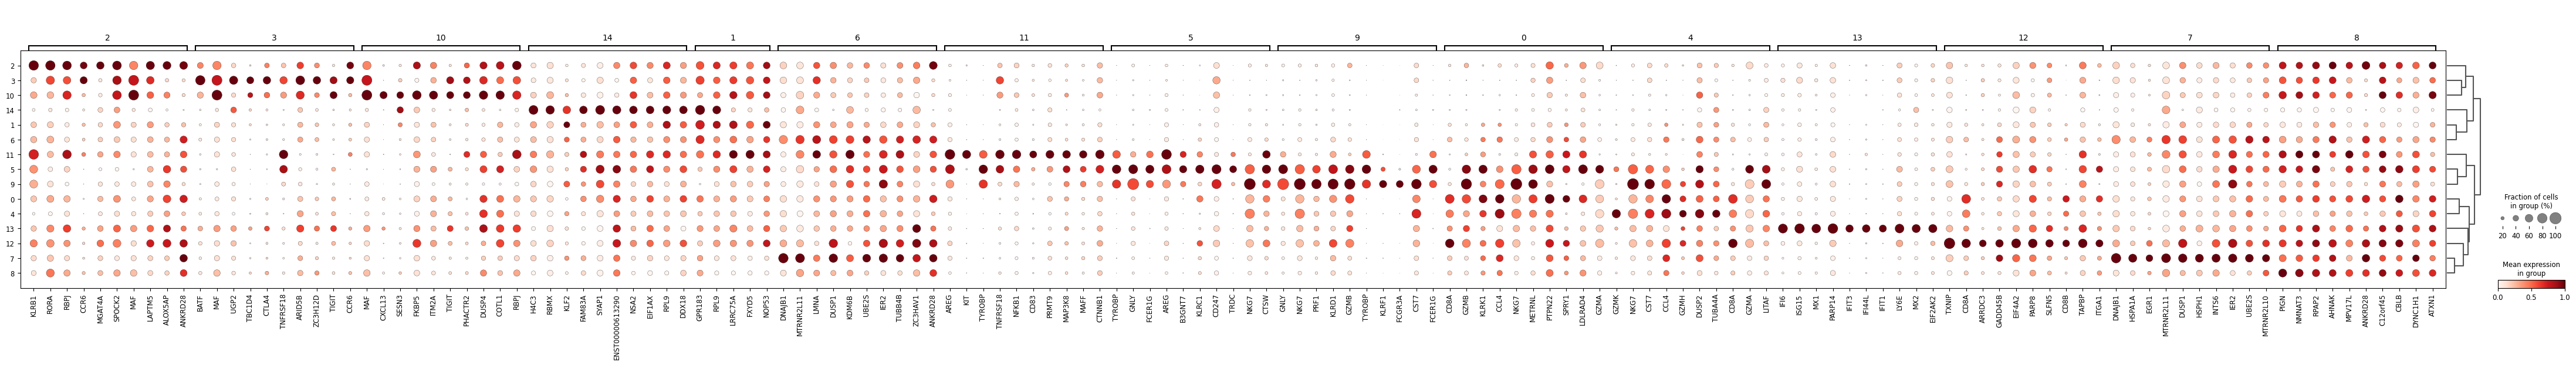

In [41]:
sc.tl.dendrogram(A, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

/tmp/ipykernel_150191/3664034353.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


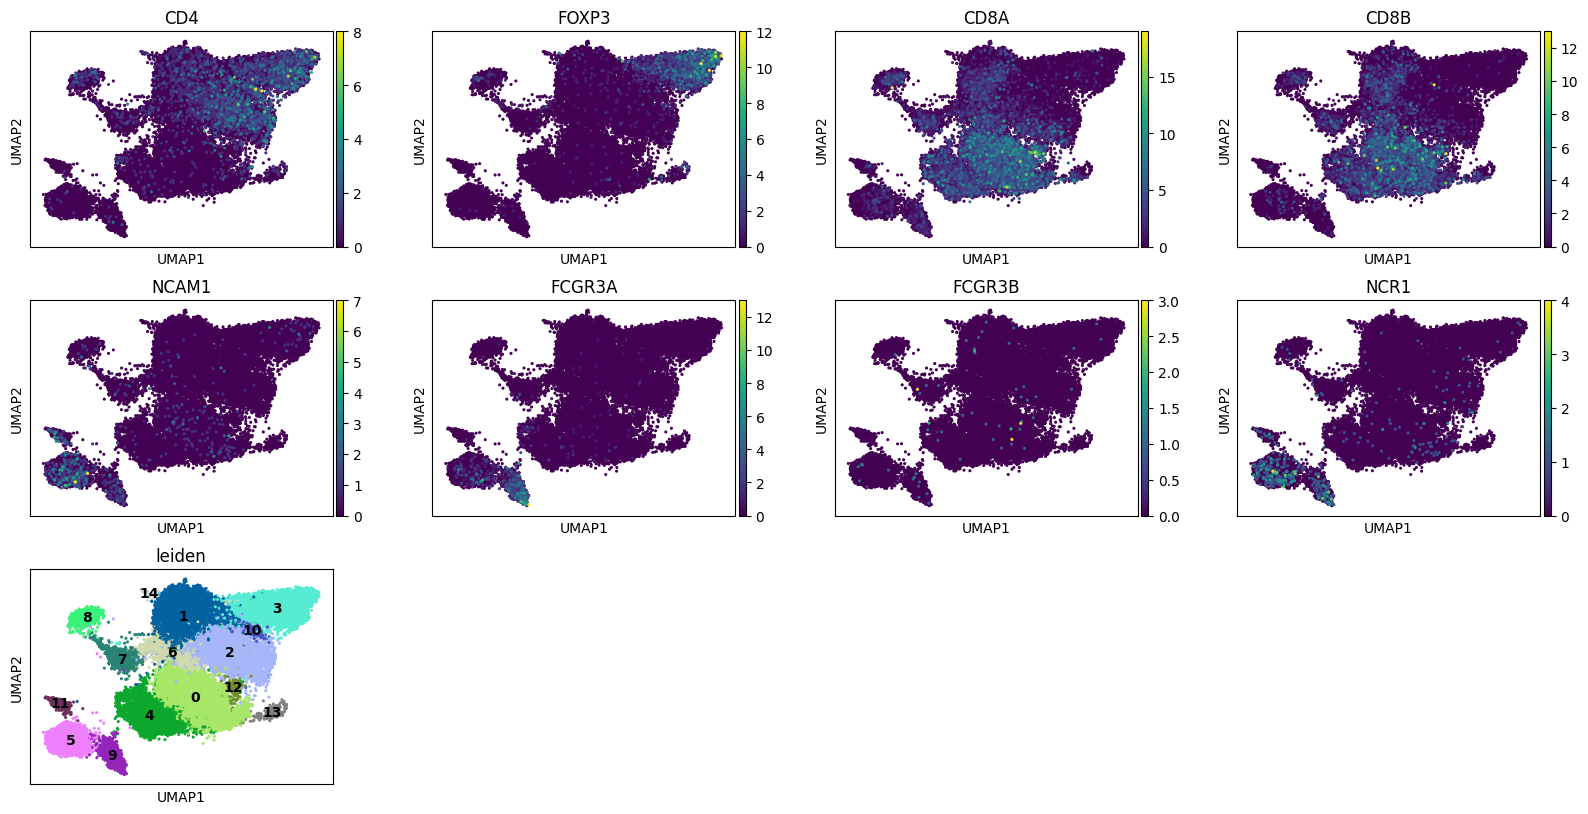

/tmp/ipykernel_150191/3664034353.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


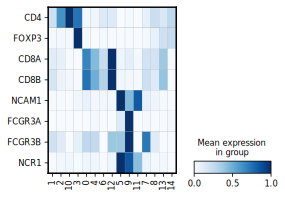

In [28]:
genes =['CD4',
       'FOXP3',
        'CD8A','CD8B',
        #NK
        'NCAM1','FCGR3A', 'FCGR3B', 'NCR1',
]
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/Tcell_markers_matrix.svg')